In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

In [5]:
# Format xml data
from xml.dom import minidom
import pandas as pd

abstracts = []
tags = []

xmldoc = minidom.parse('TrainInclude.xml')
itemlist = xmldoc.getElementsByTagName('abstract')
for node in xmldoc.getElementsByTagName('abstract'):
    abstract = node.getElementsByTagName('style')[0].firstChild.nodeValue
    abstracts.append(abstract)
    tags.append(1)
    
xmldoc = minidom.parse('TrainExclude.xml')
itemlist = xmldoc.getElementsByTagName('abstract')
for node in xmldoc.getElementsByTagName('abstract'):
    abstract = node.getElementsByTagName('style')[0].firstChild.nodeValue
    abstracts.append(abstract)
    tags.append(0)

In [7]:
df = pd.DataFrame(list(zip(tags, abstracts)), 
               columns =['code', 'abstract'])
df.head()

,code,abstract
0,1,OBJECTIVE: Urinary tract infections still repr...
1,1,OBJECTIVE: Urinary tract infections still repr...
2,1,This study aims to evaluate the effects of a h...
3,1,This study aims to evaluate the effects of a h...
4,1,BACKGROUND: It has been suggested that probiot...


In [ ]:
print("Max length of string:", df.abstract.map(len).max())

In [8]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

scibert_model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased",
                                  output_hidden_states=True)
scibert_tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

print('scibert_tokenizer is type:', type(scibert_tokenizer))
print('    scibert_model is type:', type(scibert_model))

scibert_tokenizer is type: <class 'transformers.tokenization_bert.BertTokenizer'>
    scibert_model is type: <class 'transformers.modeling_bert.BertModel'>


In [9]:
def get_embedding(model, tokenizer, text):

    # Encode with special tokens ([CLS] and [SEP], returning pytorch tensors
    encoded_dict = tokenizer.encode_plus(
                        text,
                        truncation=True,
                        max_length=512,
                        add_special_tokens = True,
                        return_tensors = 'pt'
                )

    input_ids = encoded_dict['input_ids']
    
    # Set model to evaluation mode
    model.eval()
    
    # Run through BERT
    with torch.no_grad():

        outputs = model(input_ids)

        # Extract hidden states
        hidden_states = outputs[2]

    # Select the embeddings
    token_vecs = hidden_states[-2][0]

    # Calculate average of token vectors
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to np array
    sentence_embedding = sentence_embedding.detach().numpy()

    return sentence_embedding

In [10]:
from IPython.display import clear_output
import timeit

embeddings = []
length = len(df['abstract'].tolist())
index = 0

start = timeit.default_timer()
for sentence in df['abstract'].tolist():
    clear_output(wait=True)
    index += 1
    sen_emb = get_embedding(scibert_model, scibert_tokenizer, sentence)
    embeddings.append(sen_emb)

    stop = timeit.default_timer()

    if (index/length*100) < 1:
        expected_time = "Calculating..."

    else:
        time_perc = timeit.default_timer()
        expected_time = np.round( (time_perc-start) /(index/length) /60,2)

    print(index, length)
    print(expected_time)

print(len(embeddings))

1106 1106
8.7
1106


In [11]:
df['scibert'] = embeddings
df.head(30)

,code,abstract,scibert
0,1,OBJECTIVE: Urinary tract infections still repr...,"[-0.07536177, -0.06736588, -0.37270182, 0.5410..."
1,1,OBJECTIVE: Urinary tract infections still repr...,"[-0.07536177, -0.06736588, -0.37270182, 0.5410..."
2,1,This study aims to evaluate the effects of a h...,"[-0.049732774, 0.14015731, -0.08440088, 0.2876..."
3,1,This study aims to evaluate the effects of a h...,"[-0.049732774, 0.14015731, -0.08440088, 0.2876..."
4,1,BACKGROUND: It has been suggested that probiot...,"[0.22030136, -0.32066062, -0.17968939, 0.64076..."
5,1,BACKGROUND: It has been suggested that probiot...,"[0.22030136, -0.32066062, -0.17968939, 0.64076..."
6,1,OBJECTIVE: To assess whether the use of simple...,"[0.20928083, -0.11177282, -0.23225263, 0.34750..."
7,1,OBJECTIVE: To assess whether the use of simple...,"[0.20928083, -0.11177282, -0.23225263, 0.34750..."
8,1,"BACKGROUND: In the UK, urinary tract infection...","[0.27049634, -0.020403527, -0.40627086, 0.4361..."
9,1,"BACKGROUND: In the UK, urinary tract infection...","[0.27049634, -0.020403527, -0.40627086, 0.4361..."


In [12]:
# Save dataframe to prevent recalculation
df.to_pickle("./df_screeningUTI.pkl")

In [26]:
df = pd.read_pickle("./df_screeningUTI.pkl")
df.head(20)

,code,abstract,scibert
0,1,OBJECTIVE: Urinary tract infections still repr...,"[-0.07536177, -0.06736588, -0.37270182, 0.5410..."
1,1,OBJECTIVE: Urinary tract infections still repr...,"[-0.07536177, -0.06736588, -0.37270182, 0.5410..."
2,1,This study aims to evaluate the effects of a h...,"[-0.049732774, 0.14015731, -0.08440088, 0.2876..."
3,1,This study aims to evaluate the effects of a h...,"[-0.049732774, 0.14015731, -0.08440088, 0.2876..."
4,1,BACKGROUND: It has been suggested that probiot...,"[0.22030136, -0.32066062, -0.17968939, 0.64076..."
5,1,BACKGROUND: It has been suggested that probiot...,"[0.22030136, -0.32066062, -0.17968939, 0.64076..."
6,1,OBJECTIVE: To assess whether the use of simple...,"[0.20928083, -0.11177282, -0.23225263, 0.34750..."
7,1,OBJECTIVE: To assess whether the use of simple...,"[0.20928083, -0.11177282, -0.23225263, 0.34750..."
8,1,"BACKGROUND: In the UK, urinary tract infection...","[0.27049634, -0.020403527, -0.40627086, 0.4361..."
9,1,"BACKGROUND: In the UK, urinary tract infection...","[0.27049634, -0.020403527, -0.40627086, 0.4361..."


In [ ]:
# Sample even number from each class
even_df = df.groupby('code').apply(lambda x: x.sample(n=25)).reset_index(drop=True)
even_df = even_df.sample(frac=1)
even_df.head(50)
train_data = even_df['scibert'].tolist()
train_labels = even_df['code'].tolist()

# Sample even number from each class
test_df = df.groupby('code').apply(lambda x: x.sample(n=25)).reset_index(drop=True)
test_df = test_df.sample(frac=1)
test_df.head(50)
test_data = test_df['scibert'].tolist()
test_labels = test_df['code'].tolist()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# Fit models
# Predictions for each model

f1 = []
mcc = []
acc = []

for i in range(51):
    if i > 2:
        model.fit(train_data[:i], train_labels[:i])
        pred = model.predict(test_data)
        # Evaluate
        f1.append(f1_score(test_labels, pred, pos_label=1))
        mcc.append(matthews_corrcoef(test_labels, pred))
        acc.append(accuracy_score(test_labels, pred))

print(confusion_matrix(test_labels, pred))
print(acc[-1])
        
plt.figure(figsize = (15,8))
plt.xticks(np.arange(0, 50, step=5))
plt.yticks(np.arange(0, 1.1, step=0.1))
f, = plt.plot(range(50)[2:], f1)
# m, = plt.plot(range(50)[2:], mcc)
a, = plt.plot(range(50)[2:], acc)
plt.legend([f, a], ["f1", "accuracy"])
plt.ylim(0, 1)
plt.show()

In [ ]:
# Sample even number from each class
even_df = df.groupby('code').apply(lambda x: x.sample(n=25)).reset_index(drop=True)
even_df = even_df.sample(frac=1)
even_df.head(50)

from sklearn.model_selection import train_test_split
train, test = train_test_split(even_df, test_size=0.2)

train_data = train['scibert'].tolist()
train_labels = train['code'].tolist()

test_data = test['scibert'].tolist()
test_labels = test['code'].tolist()

print(len(train_data))

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# Fit models
# Predictions for each model

f1 = []
mcc = []
acc = []

for i in range(41):
    if i > 2:
        model.fit(train_data[:i], train_labels[:i])
        pred = model.predict(test_data)
        # Evaluate
        f1.append(f1_score(test_labels, pred, pos_label=1))
        mcc.append(matthews_corrcoef(test_labels, pred))
        acc.append(accuracy_score(test_labels, pred))
#     print(confusion_matrix(test_labels, pred))
       
conf_matrix = confusion_matrix(test_labels, pred)
print(conf_matrix)

plt.figure(figsize = (15,8))
plt.yticks(np.arange(0, 1, step=0.1))
f, = plt.plot(range(40)[2:], f1)
m, = plt.plot(range(40)[2:], mcc)
a, = plt.plot(range(40)[2:], acc)
plt.legend([f, m, a], ["f1", "mcc", "accuracy"])
plt.show()

In [27]:
all_df = df.sample(frac=1)
train_data = all_df['scibert'].tolist()
train_labels = all_df['code'].tolist()
all_df.head()

,code,abstract,scibert
755,0,PURPOSE: The goal of this study was to compare...,"[0.3081869, -0.23400734, -0.32194912, 0.450021..."
1085,0,OBJECTIVE: To observe the impact of Sanjin tab...,"[-0.097583264, -0.5362855, -0.44722265, 0.5203..."
1015,0,The aim of the present study was to assess the...,"[0.23529585, 0.05285702, -0.1310215, 0.7611824..."
436,0,A prospective randomized study was conducted i...,"[0.2721983, -0.20305914, -0.54516464, 0.373920..."
367,0,This is a multi‐centric randomized controlled ...,"[0.018755104, -0.017504985, -0.26291314, 0.658..."


[[1072    0]
 [   0   34]]


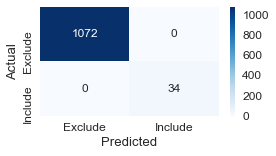

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=2.5, max_iter=1000)

model.fit(train_data, train_labels)
pred = model.predict(train_data)
       
conf_matrix = confusion_matrix(train_labels, pred)
print(conf_matrix)

labels = ["Exclude", "Include"]
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,2))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()


[[1016   56]
 [   0   34]]


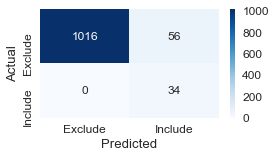

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns

model = LogisticRegression(C=0.05, class_weight='balanced', max_iter=1000)

model.fit(train_data, train_labels)
pred = model.predict(train_data)
       
conf_matrix = confusion_matrix(train_labels, pred)
print(conf_matrix)

labels = ["Exclude", "Include"]
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,2))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [42]:
xmldoc = minidom.parse('TestInclude.xml')
abstracts = []
tags = []

itemlist = xmldoc.getElementsByTagName('abstract')
for node in xmldoc.getElementsByTagName('abstract'):
    abstract = node.getElementsByTagName('style')[0].firstChild.nodeValue
    abstracts.append(abstract)
    tags.append(1)
    
test_df = pd.DataFrame(list(zip(tags, abstracts)), 
               columns =['code', 'abstract'])
test_df.head()

from IPython.display import clear_output
import timeit

embeddings = []
length = len(test_df['abstract'].tolist())
index = 0

start = timeit.default_timer()
for sentence in test_df['abstract'].tolist():
    clear_output(wait=True)
    index += 1
    sen_emb = get_embedding(scibert_model, scibert_tokenizer, sentence)
    embeddings.append(sen_emb)

    stop = timeit.default_timer()

    if (index/length*100) < 1:
        expected_time = "Calculating..."

    else:
        time_perc = timeit.default_timer()
        expected_time = np.round( (time_perc-start) /(index/length) /60,2)

    print(index, length)
    print(expected_time)

print(len(embeddings))

test_df['scibert'] = embeddings
test_df.head(30)

test_df = test_df.sample(frac=1)
test_data = test_df['scibert'].tolist()
test_labels = test_df['code'].tolist()
test_df.head()

pred = model.predict(test_data)
       
conf_matrix = confusion_matrix(test_labels, pred)
print(conf_matrix)

labels = ["Exclude", "Include"]
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,2))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

5 5
0.05
5
[[5]]


ValueError: Shape of passed values is (1, 1), indices imply (2, 2)

# Import and Preprocess/Format Data

In [ ]:
# Function which does everything below at once
def open_format_data(filename):
  # Save data from txt into list
  f = open(filename, "r")

  list_data = []
  for x in f:
      list_data.append(f.readline().rstrip().split("\t"))

  # Load list into dataframe
  column_names = ['label', "sentence"]
  df = pd.DataFrame(list_data, columns= column_names)
  df.head(10)

  # Drop any null values
  df = df.dropna()

  # Drop duplicates
  df = df.drop_duplicates()

  # Append number representing label as code
  df.label = pd.Categorical(df.label)
  df['code'] = df.label.cat.codes
  return df

In [ ]:
df = open_format_data("train.txt")

# Data Exploration

In [ ]:
df.count()

In [ ]:
df.dtypes

In [ ]:
df.groupby("label").count()

In [ ]:
df.groupby("label")['sentence'].count().plot.bar()
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# SciBERT Model For Sentence Embeddings


In [ ]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

In [ ]:
scibert_model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased",
                                  output_hidden_states=True)
scibert_tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

print('scibert_tokenizer is type:', type(scibert_tokenizer))
print('    scibert_model is type:', type(scibert_model))

In [ ]:
def get_embedding(model, tokenizer, text):

    # Encode with special tokens ([CLS] and [SEP], returning pytorch tensors
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        return_tensors = 'pt'
                )

    input_ids = encoded_dict['input_ids']
    
    # Set model to evaluation mode
    model.eval()
    
    # Run through BERT
    with torch.no_grad():

        outputs = model(input_ids)

        # Extract hidden states
        hidden_states = outputs[2]

    # Select the embeddings
    token_vecs = hidden_states[-2][0]

    # Calculate average of token vectors
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to np array
    sentence_embedding = sentence_embedding.detach().numpy()

    return sentence_embedding

In [ ]:
from IPython.display import clear_output
import timeit

embeddings = []
length = len(df['sentence'].tolist())
index = 0

start = timeit.default_timer()
for sentence in df['sentence'].tolist():
    clear_output(wait=True)
    index += 1
    sen_emb = get_embedding(scibert_model, scibert_tokenizer, sentence)
    embeddings.append(sen_emb)

    stop = timeit.default_timer()

    if (index/length*100) < 1:
        expected_time = "Calculating..."

    else:
        time_perc = timeit.default_timer()
        expected_time = np.round( (time_perc-start) /(index/length) /60,2)

    print(index, length)
    print(expected_time)

print(len(embeddings))

In [ ]:
df.head()

In [ ]:
df['scibert'] = embeddings
df.head()

In [ ]:
# Save dataframe to prevent recalculation
df.to_pickle("./df_embeddings.pkl")

# Investigating SciBert Embedded Models

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
df = pd.read_pickle("./df_embeddings.pkl")
df.head(20)

In [ ]:
# Export to weka
export_df = pd.DataFrame(df['scibert'][:2500].tolist(), index=df.index[:2500])
export_df['label'] = df['label'][:2500]

export_df.to_csv('./weka.csv', index=False)

export_df = pd.DataFrame(df['scibert'][2500:3500].tolist(), index=df.index[2500:3500])
export_df['label'] = df['label'][2500:3500]
export_df.to_csv('./weka_test.csv', index=False)

# Weka Metrics
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = [[72, 12, 13, 28, 2], 
               [18, 99, 7, 7, 28], 
               [6, 0, 306, 10, 18],
               [16, 7, 10, 33, 0],
               [ 1, 4, 16, 0, 287]]
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,2))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [ ]:
# kNN with scikit-learn
import timeit
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(8, metric="manhattan", n_jobs=-1)
# Fit models
start = timeit.default_timer()
model.fit(df['scibert'][:2500].tolist(), df['label'][:2500].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
stop = timeit.default_timer()
print("Time elapsed:", stop-start)
# Evaluate
print("F1 Score")
print(f1_score(df['label'][2500:3500].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][2500:3500].tolist(), pred))
print(classification_report(df['label'][2500:3500].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][2500:3500].tolist(), pred, labels=labels)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [ ]:
# kNN from scratch
import timeit
import heapq

def knn(k, test_data, train_data, train_label):
    pred = []
    # Iterate over each input data case
    for test_embedding in test_data[:20]:
        # List to hold (distance, label)
        distances = []
        # Calculate distance of data point from each train_data case
        for i in range(len(train_data)):
            manhattan_dist = 0
            # Iterate over each dimension of the embedding
            for x in range(len(test_embedding)):
                manhattan_dist += abs(test_embedding[x] - train_data[i][x])
            # Append (distance, label)
            distances.append((manhattan_dist, train_label[i]))
        # Find k-nearest neighbors
        k_smallest = heapq.nsmallest(k, distances)
        # Select just labels
        labels = [lis[1] for lis in k_smallest]
        # Find mode (in tie will select first appearing neighbor)
        label = max(set(labels), key=labels.count)
        pred.append(label)
    return pred
            
train_data = df['scibert'][:2500].tolist()
train_label = df['code'][:2500].tolist()
test_data = df['scibert'][2500:3500].tolist()
test_labels = df['code'][2500:3500].tolist()

# Run knn
start = timeit.default_timer()
pred = knn(5, test_data, train_data, train_label)
stop = timeit.default_timer()
print("Time elapsed:", stop-start)

# Evaluate
# print("F1 Score")
# print(f1_score(test_labels[:20], pred, average="macro"))
# print("MCC")
# print(matthews_corrcoef(test_labels[:20], pred))
# print("Accuracy")
# print(accuracy_score(test_labels[:20], pred))
# print(confusion_matrix(test_labels[:20], pred))

In [ ]:
# kNN improved with numpy
import timeit
import heapq
# import Numpy for more efficient manhattan distance
import numpy as np

def knn(k, test_data, train_data, train_label):
    test_arr = np.array(test_data)
    train_arr = np.array(train_data)
    pred = []
    # Iterate over each input data case
    for test_embedding in test_arr:
        # List to hold (distance, label)
        distances = []
        # Calculate distance of data point from each train_data case
        for i in range(len(train_arr)):
            manhattan_dist = np.sum(np.abs(test_embedding-train_arr[i]))
            # Append (distance, label)
            distances.append((manhattan_dist, train_label[i]))
        # Find k-nearest neighbors
        k_smallest = heapq.nsmallest(k, distances)
        # Select just labels
        labels = [lis[1] for lis in k_smallest]
        # Find mode (in tie will select first appearing neighbor)
        label = max(set(labels), key=labels.count)
        pred.append(label)
    return pred
            
train_data = df['scibert'][:2500].tolist()
train_label = df['code'][:2500].tolist()
test_data = df['scibert'][2500:3500].tolist()

# Run knn
start = timeit.default_timer()
pred = knn(8, test_data, train_data, train_label)
stop = timeit.default_timer()
print("Time elapsed:", stop-start)

# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(classification_report(df['code'][2500:3500].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['code'][2500:3500].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [ ]:
# Sample even number from each class
even_df = df.groupby('code').apply(lambda x: x.sample(n=500))
even_df = even_df[(even_df['label'] == 'METHODS') | (even_df['label'] == 'OBJECTIVE')].reset_index(drop = True)
even_df.label.cat.remove_unused_categories(True)
even_df = even_df.sample(frac=1).reset_index(drop=True)

even_test = df.groupby('code').apply(lambda x: x.sample(n=200))
even_test = even_test[(even_test['label'] == 'METHODS') | (even_test['label'] == 'OBJECTIVE')].reset_index(drop = True)
even_test.label.cat.remove_unused_categories(True)
even_test = even_test.sample(frac=1).reset_index(drop=True)

# KNN with balanced data
train_data = even_df['scibert'].tolist()
train_labels = even_df['label'].tolist()
test_data = even_test['scibert'].tolist()
test_labels = even_test['label'].tolist()

from sklearn.neighbors import KNeighborsClassifier
model_even = KNeighborsClassifier(metric="manhattan", n_jobs=-1)
model_even.fit(train_data, train_labels)
pred_even = model_even.predict(test_data)

print(f1_score(test_labels, pred_even, average="macro"))
print(matthews_corrcoef(test_labels, pred_even))
print(accuracy_score(test_labels, pred_even))
print(classification_report(test_labels, pred_even))

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model_even = BernoulliNB()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model_even = GaussianNB()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model_even = DecisionTreeClassifier()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(multi_class="ovr", max_iter=1000)
model_even = LinearSVC(multi_class="ovr", max_iter=1000)
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=0.02, C=2)
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['label'][:2500].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())

# Evaluate
print("F1 Score")
print(f1_score(df['label'][2500:3500].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][2500:3500].tolist(), pred))
print(classification_report(df['label'][2500:3500].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][2500:3500].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [ ]:
# from sklearn.svm import SVC
# model = SVC(kernel='rbf', gamma=0.02, C=2)
# from sklearn.svm import LinearSVC
# model = LinearSVC()
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# Fit models
# Predictions for each model

f1 = []
mcc = []
acc = []

for i in range(51):
    if i > 2:
        model.fit(train_data[:i], train_labels[:i])
        pred = model.predict(test_data)
        # Evaluate
        f1.append(f1_score(test_labels, pred, pos_label="METHODS"))
        mcc.append(matthews_corrcoef(test_labels, pred))
        acc.append(accuracy_score(test_labels, pred))
#     print(confusion_matrix(test_labels, pred))
        
plt.figure(figsize = (15,8))
plt.yticks(np.arange(0, 1, step=0.1))
f, = plt.plot(range(50)[2:], f1)
m, = plt.plot(range(50)[2:], mcc)
a, = plt.plot(range(50)[2:], acc)
plt.legend([f, m, a], ["f1", "mcc", "accuracy"])
plt.show()

In [ ]:
from sklearn.svm import SVC
model = SVC()
# Fit models
model.fit(df['scibert'][:25000].tolist(), df['label'][:25000].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][25000:35000].tolist())

# Evaluate
print("F1 Score")
print(f1_score(df['label'][25000:35000].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][25000:35000].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][25000:35000].tolist(), pred))
print(classification_report(df['label'][25000:35000].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][25000:35000].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [ ]:
fro m sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=0.02, C=2)
# Fit models
model.fit(df['scibert'][:25000].tolist(), df['label'][:25000].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][25000:35000].tolist())

# Evaluate
print("F1 Score")
print(f1_score(df['label'][25000:35000].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][25000:35000].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][25000:35000].tolist(), pred))
print(classification_report(df['label'][25000:35000].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][25000:35000].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [ ]:
# Even data
from sklearn.svm import SVC
model_even = SVC(kernel='rbf', gamma=0.02, C=2)
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
pred_even = model_even.predict(even_test['scibert'].tolist())
print(f1_score(even_test['code'].tolist(), pred_even, average="macro"))
print(matthews_corrcoef(even_test['code'].tolist(), pred_even))
print(accuracy_score(even_test['code'].tolist(), pred_even))
print(confusion_matrix(even_test['code'].tolist(), pred_even))

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="ovr", max_iter=1000)
model_even = LogisticRegression(multi_class="ovr", max_iter=1000)
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))
print(confusion_matrix(df['code'][2500:3500].tolist(), pred_even))

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
model_even = MLPClassifier()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

In [ ]:
from sklearn.linear_model import Perceptron
model = Perceptron()
model_even = Perceptron()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

In [ ]:
# Tensorflow NN
import numpy as np

# Build model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(768, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(5))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

train_em = df['scibert'][:2500]
train_em = np.array(train_em.tolist())
train_label = df['code'][:2500]
train_label = np.array(train_label.tolist())

test_em = df['scibert'][2500:3500]
test_em = np.array(test_em.tolist())
test_label = df['code'][2500:3500]
test_label = np.array(test_label.tolist())

# Fit Model
model.fit(train_em, train_label, epochs=4, validation_data=(test_em, test_label))

eval_loss, eval_acc = model.evaluate(test_em, test_label)
print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

pred = model.predict(test_em).argmax(axis=-1)

# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print("Confusion Matrix")
print(confusion_matrix(df['code'][2500:3500].tolist(), pred))